In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from WindPy import w

1.从wind获取基础数据的示范代码
2.绘制股票收益率和波动率，pct_change和volatility
3.绘制QQ图：quantile-quantile plot, 用于直观检验数据是否服从正态分布
4.股票相关性：portfolio两两的相关系数，单只股票与市场的相关性，单只股票与市场的滚动相关性
5.两种移动平均：简单移动平均SMA，指数移动平均EMA（EWMA）
6.CAPM模型：从wind获取数据，实测计算beta
7.SML和CML：证券市场线和资本市场曲线
8.APT模型：虚拟数据测试

In [4]:
# 链接wind端口
w.start()
w.isconnected()

True

In [5]:
# 从wind获取单只股票原始数据示意
data = w.wsd("600036.SH", "open,high,low,close,volume,amt,pct_chg", "2023-01-01", "2023-12-31", "unit=1;Period=M;ShowBlank=0", usedf=True)[1]
data

,OPEN,HIGH,LOW,CLOSE,VOLUME,AMT,PCT_CHG
2023-01-31,37.08,42.63,36.53,41.21,9.145158e+08,3.630028e+10,10.601181
2023-02-28,41.64,41.69,36.68,37.31,1.170397e+09,4.476477e+10,-9.463722
2023-03-31,37.25,38.77,33.71,34.27,1.277493e+09,4.518802e+10,-8.147950
2023-04-28,34.31,36.35,32.14,33.60,1.247986e+09,4.256906e+10,-1.955063
2023-05-31,33.29,36.10,32.16,32.30,1.051270e+09,3.590590e+10,-3.869048
2023-06-30,32.31,34.25,32.02,32.76,7.529518e+08,2.504693e+10,1.424149
2023-07-31,32.90,36.04,31.26,35.56,1.049290e+09,3.482478e+10,14.550561
2023-08-31,35.53,35.58,30.80,31.55,1.447640e+09,4.741372e+10,-11.276715
2023-09-28,31.95,33.61,31.88,32.97,9.216512e+08,3.036790e+10,4.500792
2023-10-31,32.70,33.33,30.55,30.76,7.087126e+08,2.257532e+10,-6.703063


In [7]:
# 数据量的的时候，为了避免多次读取数据，可以保存为csv文件
data.to_csv("600036SH.csv")
df = pd.read_csv("600036SH.csv")
df.rename(columns={'Unnamed: 0': 'DATE'}, inplace=True)
df

,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,AMT,PCT_CHG
0,2023-01-31,37.08,42.63,36.53,41.21,9.145158e+08,3.630028e+10,10.601181
1,2023-02-28,41.64,41.69,36.68,37.31,1.170397e+09,4.476477e+10,-9.463722
2,2023-03-31,37.25,38.77,33.71,34.27,1.277493e+09,4.518802e+10,-8.147950
3,2023-04-28,34.31,36.35,32.14,33.60,1.247986e+09,4.256906e+10,-1.955063
4,2023-05-31,33.29,36.10,32.16,32.30,1.051270e+09,3.590590e+10,-3.869048
5,2023-06-30,32.31,34.25,32.02,32.76,7.529518e+08,2.504693e+10,1.424149
6,2023-07-31,32.90,36.04,31.26,35.56,1.049290e+09,3.482478e+10,14.550561
7,2023-08-31,35.53,35.58,30.80,31.55,1.447640e+09,4.741372e+10,-11.276715
8,2023-09-28,31.95,33.61,31.88,32.97,9.216512e+08,3.036790e+10,4.500792
9,2023-10-31,32.70,33.33,30.55,30.76,7.087126e+08,2.257532e+10,-6.703063


In [8]:
# 画图参数预设
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
print(matplotlib.__version__)

3.9.0


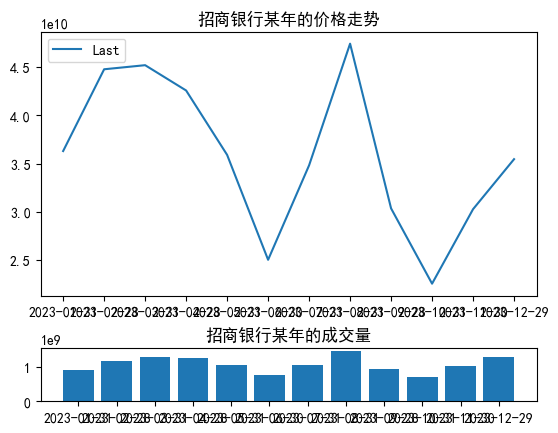

In [14]:
"""plt.subplot2grid()
股票量价图"""
top = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)
top.plot(df['DATE'], df['AMT'], label='Last')
plt.title('招商银行某年的价格走势')
plt.legend(loc=2)

bottom = plt.subplot2grid((4, 4), (3, 0), rowspan=1, colspan=4)
bottom.bar(df['DATE'], df['VOLUME'])
plt.title('招商银行某年的成交量')
plt.subplots_adjust(hspace=1)
plt.show()

0           NaN
1     -9.463722
2     -8.147950
3     -1.955063
4     -3.869048
5      1.424149
6      8.547009
7    -11.276715
8      4.500792
9     -6.703063
10    -6.404421
11    -3.369225
Name: CLOSE, dtype: float64
6.099045332032742


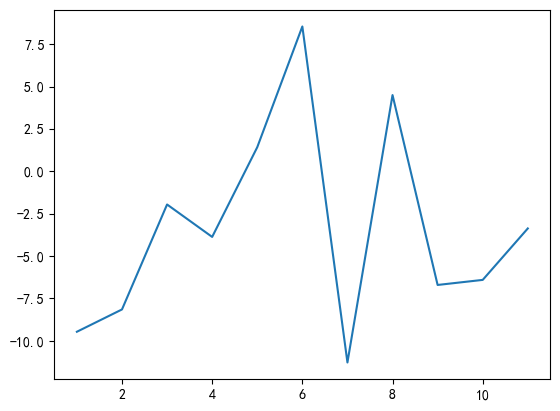

In [16]:
# series和df自带计算收益率的函数
# volatility需要计算std，返回的是一个float数值
df_pct_change = df['CLOSE'].pct_change()*100
df_volatility = df['CLOSE'].pct_change().std()*100
print(df_pct_change)
df_pct_change.plot()
print(df_volatility)

,pct_change,cumsum,pct_change1,cumprod
0,NaN,NaN,NaN,NaN
1,-9.463722,-9.463722,0.905363,-9.463722
2,-8.147950,-17.611672,0.918521,-16.840573
3,-1.955063,-19.566735,0.980449,-18.466392
4,-3.869048,-23.435782,0.961310,-21.620966
5,1.424149,-22.011634,1.014241,-20.504732
6,8.547009,-13.464625,1.085470,-13.710264
7,-11.276715,-24.741341,0.887233,-23.440912
8,4.500792,-20.240548,1.045008,-19.995147
9,-6.703063,-26.943612,0.932969,-25.357923


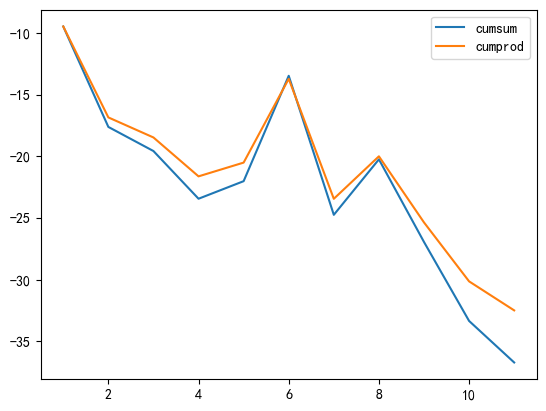

In [24]:
# cumsum函数是逐个累计相加，算数意义上的累加，其实就是没考虑复利
df_cumsum = df_pct_change.cumsum()
# cumprod累计乘积，就是考虑了复利的情况
df_cumprod = ((df_pct_change/100+1).cumprod()-1)*100
df_cumsum_cumprod = pd.DataFrame({'pct_change': df_pct_change, 'cumsum':df_cumsum, 'pct_change1': df_pct_change/100+1,'cumprod':df_cumprod})
df_cumsum_cumprod[['cumsum', 'cumprod']].plot()
df_cumsum_cumprod
# 对比来看，在样本数小的时候这两种差异不大，但是样本数大的时候，cumprod的差异就比较明显了

In [25]:
# describe函数可以直接返回df或者series的统计信息
df_pct_change.describe()

count    11.000000
mean     -3.337933
std       6.099045
min     -11.276715
25%      -7.425507
50%      -3.869048
75%      -0.265457
max       8.547009
Name: CLOSE, dtype: float64

In [26]:
# 取一直股票日度高频数据做分析
df_daily = w.wsd("600036.SH", "pct_chg", "2023-01-01", "2024-07-31", "unit=1;Period=D;ShowBlank=0", usedf=True)[1]
df_daily.index.name = 'Date'
df_daily.head(10)

,PCT_CHG
Date,
2023-01-03,0.858830
2023-01-04,2.847259
2023-01-05,-0.388098
2023-01-06,-0.311688
2023-01-09,1.094320
2023-01-10,-1.417526
2023-01-11,1.751634
2023-01-12,0.334018
2023-01-13,1.562100


             PCT_CHG
Date                
2023-01-03       NaN
2023-01-04       NaN
2023-01-05       NaN
2023-01-06       NaN
2023-01-09       NaN
...              ...
2024-07-25  1.324412
2024-07-26  1.244151
2024-07-29  1.243344
2024-07-30  1.243481
2024-07-31  1.233137

[382 rows x 1 columns]


<Axes: xlabel='Date'>

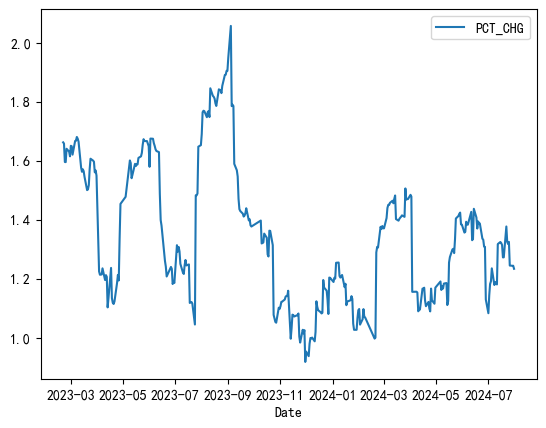

In [27]:
# rolling函数很重要，取当前点后特定window的数据做统计计算
# 这里做了一个30天的滚动标准差计算
df_std = df_daily.rolling(window=30, min_periods=30).std()
print(df_std)
df_std.plot()

array([[<Axes: title={'center': 'PCT_CHG'}>]], dtype=object)

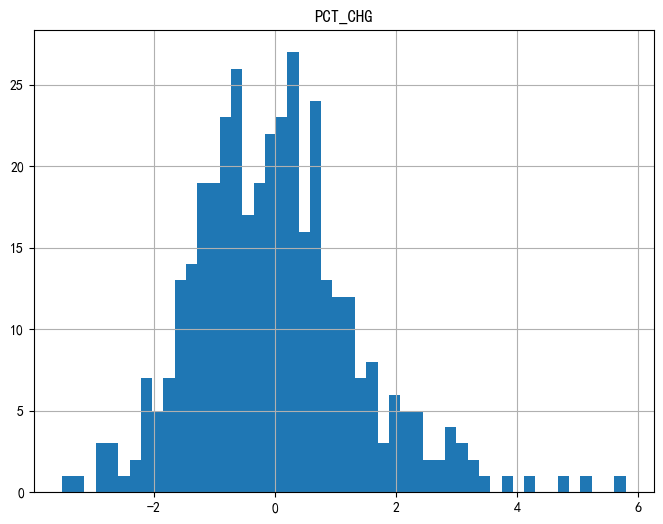

In [28]:
# 高频日度数据的直方图，看起来像一个正态分布
df_daily.hist(bins=50,figsize=(8, 6))

In [29]:
# 把非交易日缺失的数据填充为前一个交易日的数据
#df的asfreq函数很有用，可以将高频的数据降维为低频的数据，也可以根据填充缺失数据
df_daily_fill = df_daily.asfreq('D', method='ffill')
df_daily_fill.head(10)

,PCT_CHG
Date,
2023-01-03,0.858830
2023-01-04,2.847259
2023-01-05,-0.388098
2023-01-06,-0.311688
2023-01-07,-0.311688
2023-01-08,-0.311688
2023-01-09,1.094320
2023-01-10,-1.417526
2023-01-11,1.751634


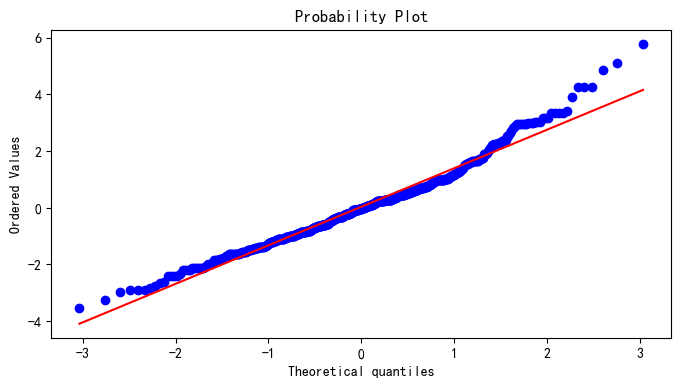

In [30]:
# Q-Q图，quantile-quantile plot，横轴是理论分布的分位数，纵轴是经验分布的分位数
# 如果越接近一条直线，那么经验数据的分布和理论分布越接近
from scipy import stats
from scipy.stats import probplot
figure = plt.figure(figsize=(8, 4))
ax = figure.add_subplot(111)
stats.probplot(df_daily_fill['PCT_CHG'], dist='norm', plot=ax)
plt.show()

In [31]:
# 从wind下载三个股票的日线数据
tickers = ['600036.SH', '600519.SH', '300750.SZ']
df_stocks = w.wsd(tickers, "close", "2023-01-01", "2024-07-31", "unit=1;Period=D;ShowBlank=0", usedf=True)[1]
df_stocks.head(5)

,600036.SH,600519.SH,300750.SZ
2023-01-03,37.58,1730.01,389.64
2023-01-04,38.65,1725.01,384.01
2023-01-05,38.50,1801.00,407.51
2023-01-06,38.38,1803.77,416.66
2023-01-09,38.80,1841.20,416.60


In [32]:
# portforlio股价变化两两的相关性
df_stocks.pct_change().corr()

,600036.SH,600519.SH,300750.SZ
600036.SH,1.000000,0.437695,0.198638
600519.SH,0.437695,1.000000,0.297761
300750.SZ,0.198638,0.297761,1.000000


In [34]:
df_stocks.index.name = 'Date'

<Axes: xlabel='Date'>

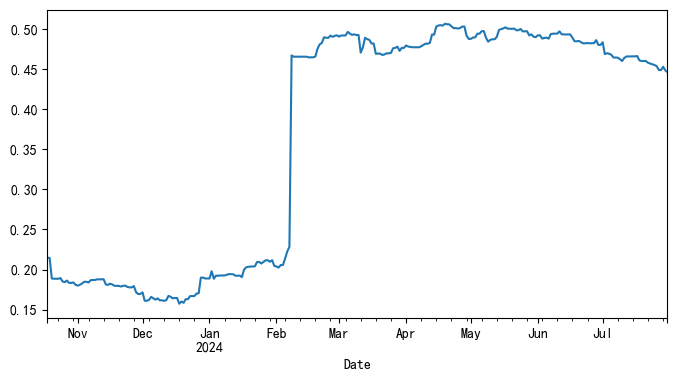

In [35]:
# 两只股票价格变化随着时间的滚动相关性
df_two = df_stocks[['300750.SZ', '600519.SH']]
df_two_filled = df_two.asfreq('D', method='ffill')
df_two_changes = df_two_filled.pct_change()
window = int(len(df_two_filled.index)/2)
df_two_corr = df_two_changes['300750.SZ'].rolling(window, min_periods=window).corr(other=df_two_changes['600519.SH']).dropna()
df_two_corr.plot(figsize=(8,4))

,Short,Long
Date,,
2023-01-03,NaN,NaN
2023-01-04,NaN,NaN
2023-01-05,NaN,NaN
2023-01-06,NaN,NaN
2023-01-09,1780.198,1780.198000
2023-01-10,1805.086,1792.573333
2023-01-11,1829.074,1800.055714
2023-01-12,1835.674,1804.298750
2023-01-13,1852.320,1813.487778


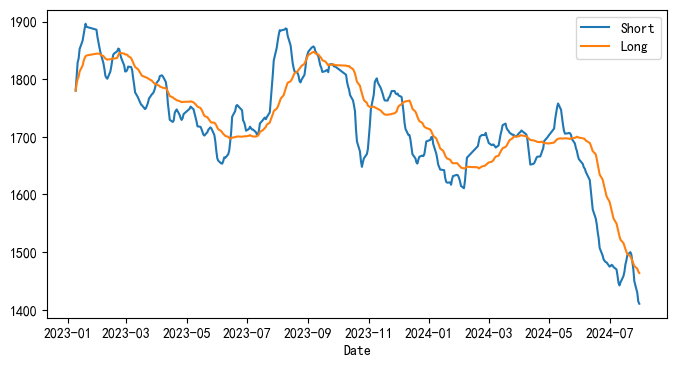

In [36]:
# SMA: simple moving average
series_short = df_stocks['600519.SH'].rolling(window=5, min_periods=5).mean()
series_long = df_stocks['600519.SH'].rolling(window=30, min_periods=5).mean()
df_sma = pd.DataFrame({'Short': series_short, 'Long': series_long})
df_sma.plot(figsize=(8, 4))
df_sma.head(10)



,Short,Long
Date,,
2023-01-03,1730.010000,1730.010000
2023-01-04,1727.010000,1727.426667
2023-01-05,1762.057895,1753.603628
2023-01-06,1779.384462,1767.426292
2023-01-09,1803.114597,1784.211597
...,...,...
2024-07-25,1456.531394,1498.232241
2024-07-26,1445.084263,1493.326290
2024-07-29,1429.396175,1487.177497


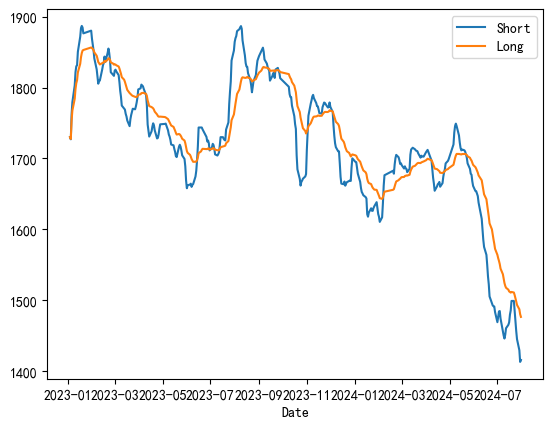

In [37]:
# EMA: Exponential Moving Average,也叫EWMA，指数加权移动平均线
series_short = df_stocks['600519.SH'].ewm(span=5).mean()
series_long = df_stocks['600519.SH'].ewm(span=30).mean()
df_ema = pd.DataFrame({'Short': series_short, 'Long': series_long})
df_ema.plot()
df_ema

In [38]:
# CAPM:资本资产定价模型
tickers = ["000300.SH", "600036.SH"]
df_capm = w.wsd(tickers, "close", "2023-01-01", "2024-07-31", "unit=1;Period=D;ShowBlank=0", usedf=True)[1]
df_capm

,000300.SH,600036.SH
2023-01-03,3887.8992,37.58
2023-01-04,3892.9477,38.65
2023-01-05,3968.5782,38.50
2023-01-06,3980.8888,38.38
2023-01-09,4013.1196,38.80
...,...,...
2024-07-25,3399.2716,32.83
2024-07-26,3409.2931,32.37
2024-07-29,3390.7420,32.45
2024-07-30,3369.3821,32.42


In [39]:
from scipy import stats
# df_capm_filled = df_capm.asfreq('D', method='ffill')
df_capm_pct_change = df_capm.pct_change().dropna()
print(df_capm_pct_change)
beta, alpha, r_value, p_value, std_err = stats.linregress(df_capm_pct_change['600036.SH'], df_capm_pct_change['000300.SH'])
print(beta, alpha, r_value, p_value, std_err)


            000300.SH  600036.SH
2023-01-04   0.001299   0.028473
2023-01-05   0.019428  -0.003881
2023-01-06   0.003102  -0.003117
2023-01-09   0.008096   0.010943
2023-01-10   0.001085  -0.014175
...               ...        ...
2024-07-25  -0.005528  -0.010549
2024-07-26   0.002948  -0.014012
2024-07-29  -0.005441   0.002471
2024-07-30  -0.006299  -0.000924
2024-07-31   0.021577   0.009562

[381 rows x 2 columns]
0.34630143521966583 -0.0001905113107711189 0.5605797992842831 6.526801111999436e-33 0.02627726992709993


In [41]:
# APT：arbitrage pricing theory
num_periods = 9
all_values = np.array([np.random.random(8) for i in range(num_periods)])
all_values

array([[0.6028715 , 0.90763262, 0.67930743, 0.70273308, 0.56166433,
        0.56078902, 0.54901712, 0.86857726],
       [0.99889102, 0.65857248, 0.43236448, 0.5809728 , 0.03413462,
        0.03689699, 0.49020551, 0.78155433],
       [0.41852054, 0.28684756, 0.89758155, 0.81343985, 0.01732701,
        0.02169971, 0.77399836, 0.09852001],
       [0.58363141, 0.68151579, 0.84649847, 0.74646988, 0.09403386,
        0.00164638, 0.44836064, 0.03182701],
       [0.82916045, 0.98888258, 0.51472471, 0.16144777, 0.13799296,
        0.7679236 , 0.55781579, 0.94003786],
       [0.83042977, 0.9039992 , 0.91859179, 0.72072861, 0.69907495,
        0.52427143, 0.87504812, 0.31920566],
       [0.55612966, 0.67950878, 0.44190655, 0.39477181, 0.46290454,
        0.92349177, 0.35164004, 0.24890027],
       [0.66036293, 0.50457983, 0.01719627, 0.44437358, 0.08701951,
        0.62630169, 0.76040019, 0.62744148],
       [0.56631704, 0.52652056, 0.03333119, 0.9150377 , 0.7301986 ,
        0.95695138, 0.120411

In [42]:
y_values = all_values[:, 0]
x_values = all_values[:, 1:]
x_values = sm.add_constant(x_values)
x_values

array([[1.        , 0.90763262, 0.67930743, 0.70273308, 0.56166433,
        0.56078902, 0.54901712, 0.86857726],
       [1.        , 0.65857248, 0.43236448, 0.5809728 , 0.03413462,
        0.03689699, 0.49020551, 0.78155433],
       [1.        , 0.28684756, 0.89758155, 0.81343985, 0.01732701,
        0.02169971, 0.77399836, 0.09852001],
       [1.        , 0.68151579, 0.84649847, 0.74646988, 0.09403386,
        0.00164638, 0.44836064, 0.03182701],
       [1.        , 0.98888258, 0.51472471, 0.16144777, 0.13799296,
        0.7679236 , 0.55781579, 0.94003786],
       [1.        , 0.9039992 , 0.91859179, 0.72072861, 0.69907495,
        0.52427143, 0.87504812, 0.31920566],
       [1.        , 0.67950878, 0.44190655, 0.39477181, 0.46290454,
        0.92349177, 0.35164004, 0.24890027],
       [1.        , 0.50457983, 0.01719627, 0.44437358, 0.08701951,
        0.62630169, 0.76040019, 0.62744148],
       [1.        , 0.52652056, 0.03333119, 0.9150377 , 0.7301986 ,
        0.95695138, 0.120411

In [43]:
results = sm.OLS(y_values, x_values).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                 -0.419
Method:                 Least Squares   F-statistic:                    0.6627
Date:                  周二, 06 8月 2024   Prob (F-statistic):              0.741
Time:                        13:12:02   Log-Likelihood:                 10.994
No. Observations:                   9   AIC:                            -5.987
Df Residuals:                       1   BIC:                            -4.409
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6396      1.420      1.154      0.4

d:\python_explore_2024\wind_data_wrangling\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [44]:
print(results.params)

[ 1.63961564  0.1110764  -0.49410374 -1.07034689  1.05715215 -1.06366228
  0.04600142  0.07375231]


In [45]:
predicts = results.predict(x_values)
print(predicts)

[0.73920537 0.95432331 0.39542365 0.61870563 0.7463831  0.75989582
 0.61581265 0.71860606 0.49795873]


<function matplotlib.pyplot.show(close=None, block=None)>

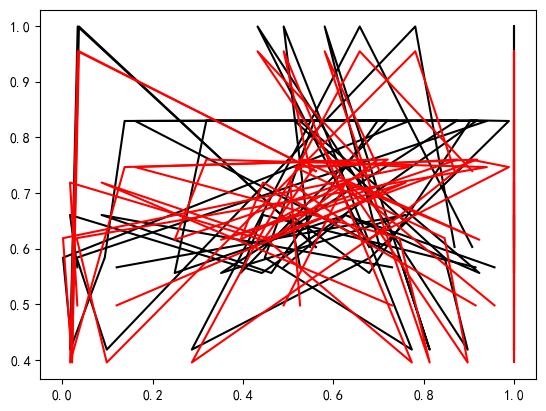

In [46]:
# 这个图画不出来，因为是多维的
plt.plot(x_values, y_values, label='实际值', color='black')
plt.plot(x_values, predicts, label='预测值', color='red')
plt.show